# Using the G-score concept to make rankings for the 2023-2024 season

In [2]:
from lightgbm import LGBMRegressor
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
import scipy
from sklearn.preprocessing import StandardScaler, LabelEncoder
from unidecode import unidecode
import lime
from src.helper_functions import cleanup_name_str, setup, calculate_coefficients, calculate_scores_from_coefficients
from lime import lime_tabular
import re
import cvxpy as cp
from lightgbm import plot_importance
pd.options.mode.chained_assignment = None

In [3]:
season_strings = [str(season - 1) + '-' + str(season)[2:] for season in [2023,2022,2021,2020]]


df = pd.concat(
    [pd.read_csv('../data/stat_data/' + season_string + '_complete.csv').assign(season = season_string) \
     for season_string in season_strings ]
)


min_split = df['MIN'].str.split(':', expand = True)
s = (60 * min_split.loc[:,0]*60 +  min_split.loc[:,1]).fillna(0)

df.loc[:,'no_play'] = s == 0


In [4]:
x = df.groupby(['PLAYER_NAME','season'])[['no_play']].mean()
x.loc[:,'no_play_lag_1'] = x.sort_values('season').groupby(['PLAYER_NAME'])['no_play'].shift(1)
x.loc[:,'no_play_lag_2'] = x.sort_values('season').groupby(['PLAYER_NAME'])['no_play'].shift(2)
x = x.dropna()

In [5]:
from statsmodels.api import OLS, add_constant

In [6]:
model = OLS(x['no_play'],add_constant(x[['no_play_lag_1','no_play_lag_2']])).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                no_play   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     147.0
Date:                Sun, 06 Aug 2023   Prob (F-statistic):           1.53e-54
Time:                        09:42:57   Log-Likelihood:                 181.21
No. Observations:                 748   AIC:                            -356.4
Df Residuals:                     745   BIC:                            -342.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0669      0.009      7.061      0.000       0.048       0.086
no_play_lag_1     0.5511      0.042     13.026      0.000       0.468       0.634
no_play_lag_2     0.1426      0.042      3.366      0.001       0.059       0.226
==============================================================================
Omnibus:                      173.719   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              410.201
Skew:                           1.224   Prob(JB):                     8.43e-90
Kurtosis:                       5.678   Cond. No.                         7.60
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
82 - 82 * 0.0669

76.5142

In [8]:
0.0795 * 82

6.519

In [9]:
df

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,...,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,date,season,no_play
0,22200001,1610612755,PHI,Philadelphia,202699,Tobias Harris,Tobias,F,NaN,34:14,...,0.0,3.0,0.0,0.0,3.0,18.0,-1.0,2022-10-18,2022-23,False
1,22200001,1610612755,PHI,Philadelphia,200782,P.J. Tucker,P.J.,F,NaN,33:01,...,0.0,0.0,1.0,2.0,2.0,6.0,-6.0,2022-10-18,2022-23,False
2,22200001,1610612755,PHI,Philadelphia,203954,Joel Embiid,Joel,C,NaN,37:16,...,5.0,0.0,1.0,6.0,4.0,26.0,-13.0,2022-10-18,2022-23,False
3,22200001,1610612755,PHI,Philadelphia,1630178,Tyrese Maxey,Tyrese,G,NaN,38:12,...,2.0,2.0,0.0,1.0,5.0,21.0,-6.0,2022-10-18,2022-23,False
4,22200001,1610612755,PHI,Philadelphia,201935,James Harden,James,G,NaN,37:16,...,7.0,0.0,0.0,3.0,3.0,35.0,1.0,2022-10-18,2022-23,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26533,21900527,1610612739,CLE,Cleveland,203089,John Henson,John,NaN,NaN,13:52,...,2.0,1.0,0.0,0.0,2.0,4.0,-3.0,2020-01-04,2019-20,False
26534,21900527,1610612739,CLE,Cleveland,1627790,Ante Zizic,Ante,NaN,NaN,3:09,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,2020-01-04,2019-20,False
26535,21900527,1610612739,CLE,Cleveland,1629731,Dean Wade,Dean,NaN,NaN,3:09,...,0.0,0.0,0.0,1.0,1.0,2.0,1.0,2020-01-04,2019-20,False
26536,21900527,1610612739,CLE,Cleveland,1629076,Tyler Cook,Tyler,NaN,DNP - Coach's Decision,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-04,2019-20,True


## 1. Data preparation

We start by loading the box score data we stored previously, and applying minor formatting changes

In [10]:
'''
def get_scores_per_season(season
                         ,n_players = 12 * 7 * 2):
    
    season_df, positions = setup(season)
        
    season_df.loc[:,'no_play'] = season_df.sum(axis = 1) == 0 
    season_df_uninjured = season_df[~season_df['no_play']]
    no_play_rate = season_df.groupby('player')['no_play'].mean()
    
    all_players = pd.unique(season_df.index.get_level_values('player'))
    mean_of_means_1, var_of_means_1, mean_of_vars_1 = calculate_coefficients(season_df, all_players)
    first_order_scores = calculate_scores_from_coefficients(season_df
                                                       ,mean_of_means_1
                                                       ,var_of_means_1
                                                       ,mean_of_vars_1
                                                       ,alpha_weight = 1
                                                       ,beta_weight = 0)

    first_order_score_totals = first_order_scores.sum(axis = 1).sort_values(ascending = False)

    representative_player_set = first_order_score_totals.index[0:n_players]
    mean_of_means_2, var_of_means_2, mean_of_vars_2 = calculate_coefficients(season_df, representative_player_set)
    
    g_scores = calculate_scores_from_coefficients(season_df_uninjured
                                                       ,mean_of_means_2
                                                       ,var_of_means_2
                                                       ,mean_of_vars_2
                                                       ,alpha_weight = 1
                                                       ,beta_weight = 1)
    
    return pd.concat({season : no_play_rate}, names = ['season']),pd.concat({season : g_scores}, names = ['season'])

#get x,g, and z scores 
'''

"\ndef get_scores_per_season(season\n                         ,n_players = 12 * 7 * 2):\n    \n    season_df, positions = setup(season)\n        \n    season_df.loc[:,'no_play'] = season_df.sum(axis = 1) == 0 \n    season_df_uninjured = season_df[~season_df['no_play']]\n    no_play_rate = season_df.groupby('player')['no_play'].mean()\n    \n    all_players = pd.unique(season_df.index.get_level_values('player'))\n    mean_of_means_1, var_of_means_1, mean_of_vars_1 = calculate_coefficients(season_df, all_players)\n    first_order_scores = calculate_scores_from_coefficients(season_df\n                                                       ,mean_of_means_1\n                                                       ,var_of_means_1\n                                                       ,mean_of_vars_1\n                                                       ,alpha_weight = 1\n                                                       ,beta_weight = 0)\n\n    first_order_score_totals = first_order_s

In [11]:
counting_statistics = ['pts', 'trb', 'ast', 'stl', 'blk', 'fg3','tov']
pct_statistics = ['fg_pct','ft_pct']

def get_stats_per_season(season):
    
    season_df, _ = setup(season)
    season_df.loc[:,'no_play'] = season_df.sum(axis = 1) == 0 
    no_play_rate = season_df.groupby('player')[['no_play']].mean()
    season_df_uninjured = season_df[~season_df['no_play']]

    counting_means = season_df_uninjured[counting_statistics].groupby('player').mean()
    
    fta_mean = season_df['fta'].groupby('player').mean()
    ftp_mean = season_df['ft'].groupby('player').mean()/fta_mean
    ftp_mean.name = 'ft_pct'
    
    fga_mean = season_df['fga'].groupby('player').mean()
    fgp_mean = season_df['fg'].groupby('player').mean()/fga_mean
    fgp_mean.name = 'fg_pct'
    
    final_df = pd.concat([counting_means,fta_mean,ftp_mean,fga_mean,fgp_mean,no_play_rate], axis = 1)
        
    return pd.concat({season : final_df},names = ['season'])


In [12]:
season_df, _ = setup(2023)

season_df.loc['Shai Gilgeous-Alexander']

,pts,trb,ast,stl,blk,fg3,tov,fg,fga,ft,fta
week,,,,,,,,,,,
42,60.0,9.0,12.0,4.0,2.0,3.0,7.0,23.0,47.0,11.0,11.0
43,95.0,16.0,23.0,8.0,4.0,4.0,8.0,36.0,72.0,19.0,19.0
44,89.0,9.0,12.0,6.0,3.0,0.0,11.0,32.0,51.0,25.0,27.0
45,129.0,19.0,21.0,7.0,9.0,5.0,14.0,47.0,84.0,30.0,34.0
46,94.0,16.0,21.0,2.0,3.0,6.0,8.0,33.0,66.0,22.0,27.0
47,123.0,23.0,28.0,5.0,3.0,2.0,8.0,37.0,84.0,47.0,49.0
48,64.0,7.0,10.0,5.0,1.0,2.0,11.0,17.0,38.0,28.0,30.0
49,84.0,11.0,15.0,4.0,1.0,1.0,13.0,21.0,49.0,41.0,43.0
50,104.0,17.0,15.0,5.0,0.0,5.0,12.0,35.0,66.0,29.0,31.0


In [14]:
seasons = range(2001,2024)

stat_df = pd.concat([get_stats_per_season(season) for season in seasons])

We will also use additional player information from basketball reference (as provided by Sumitro Datta [here](https://www.kaggle.com/datasets/sumitrodatta/nba-aba-baa-stats)) and the NBA API

In [15]:
basic_player_data = pd.read_csv('../data/raw/player_data.csv')
basic_player_data['player'] = [cleanup_name_str(x) for x in basic_player_data['player']]

basic_player_data = basic_player_data.groupby(['player','season']).first().reset_index()

additional_player_data = pd.concat([pd.read_csv('../data/raw/metadata_from_api_' + str(n) + '.csv')
                     for n in [1,2,3]]
                   ).rename(columns = {'PLAYER_NAME' : 'player'})
additional_player_data['player'] = [cleanup_name_str(x) for x in additional_player_data['player']]
additional_player_data['DRAFT_NUMBER'] = additional_player_data['DRAFT_NUMBER'].apply(pd.to_numeric, errors='coerce')

height_breakdown = additional_player_data['HEIGHT'].str.split('-')
additional_player_data['HEIGHT'] = height_breakdown.str[0].astype(float)*12 + height_breakdown.str[1].astype(float) 

player_data = pd.merge(basic_player_data
                       , additional_player_data[['player','DRAFT_NUMBER','HEIGHT','WEIGHT']]
                       , on = ['player'])

#make sure there is one row per player/season
player_data = player_data.groupby(['player','season']).first()
player_data = player_data.drop(columns = ['birth_year'])
player_data.head()

seas_id  player_id pos   age   lg   tm  experience  \
player     season                                                       
A.C. Green 1986      10180       2218  PF  22.0  NBA  LAL           1   
           1987      10559       2218  PF  23.0  NBA  LAL           2   
           1988      10937       2218  PF  24.0  NBA  LAL           3   
           1989      11363       2218  PF  25.0  NBA  LAL           4   
           1990      11801       2218  PF  26.0  NBA  LAL           5   

                   DRAFT_NUMBER  HEIGHT  WEIGHT  
player     season                                
A.C. Green 1986            23.0    81.0   225.0  
           1987            23.0    81.0   225.0  
           1988            23.0    81.0   225.0  
           1989            23.0    81.0   225.0  
           1990            23.0    81.0   225.0

In [16]:
#make sure the data is sorted by season
stat_df = stat_df.sort_values('season', ascending = True)

In [17]:
main_columns = stat_df.columns
stat_df.loc[:, [c + '_lag_1' for c in main_columns]] = stat_df[main_columns].groupby('player').shift(1).values
stat_df.loc[:, [c + '_lag_2' for c in main_columns]] = stat_df[main_columns].groupby('player').shift(2).values
stat_df.loc[:, [c + '_lag_3' for c in main_columns]] = stat_df[main_columns].groupby('player').shift(3).values
stat_df.loc[:, [c + '_lag_4' for c in main_columns]] = stat_df[main_columns].groupby('player').shift(4).values
stat_df = stat_df.merge(player_data, left_index = True, right_index = True)

## 3. Forecasting


Now we build models

In [18]:
#we dont have full data for the first 4 years, so we need to drop them
prediction_df = stat_df[stat_df.index.get_level_values('season') >= 2005]

categorical_names = {}
le = LabelEncoder()
le.fit(prediction_df.loc[:, 'pos'])
prediction_df.loc[:, 'pos_n'] = le.transform(prediction_df.loc[:, 'pos'])
categorical_names[5] = le.classes_

train = prediction_df[prediction_df.index.get_level_values('season') < 2022]

train_x = train.drop(columns = list(main_columns) + ['pos','lg','tm','seas_id','player_id'])
train_y = train[main_columns]
train_weight = 1 - train['no_play']
train_time_weight = np.array(np.exp(-0.99 * (2023 - train.index.get_level_values('season'))/20))

test = prediction_df[prediction_df.index.get_level_values('season') >= 2022]

test_x = test.drop(columns = list(main_columns) + ['pos','lg','tm','seas_id','player_id'])
test_y = test[main_columns]
test_weight = 1 - test['no_play']
test_time_weight = np.array(np.exp(-0.99 * (2023 - test.index.get_level_values('season'))/20))

future = prediction_df[prediction_df.index.get_level_values('season') == 2023]
future.index = future.index.droplevel('season')
future.loc[:,'age'] += 1
future.loc[:,'experience'] += 1
future.loc[:,[c + '_lag_4' for c in main_columns]] = future[[c + '_lag_3' for c in main_columns]].values
future.loc[:,[c + '_lag_3' for c in main_columns]] = future[[c + '_lag_2' for c in main_columns]].values
future.loc[:,[c + '_lag_2' for c in main_columns]] = future[[c + '_lag_1' for c in main_columns]].values
future.loc[:,[c + '_lag_1' for c in main_columns]] = future[main_columns].values

future_x = future.drop(columns = list(main_columns) + ['pos','lg','tm','seas_id','player_id'])


In [19]:
parameters = {'pts' : {'num_leaves' : 17
                       ,'max_depth' : 6
                       , 'boosting' : 'gbdt'
                       , 'min_data_in_leaf' : 10
                        , 'weight' : (train_weight*train_time_weight,test_weight*test_time_weight)
                       , 'features' : train_x.columns}
             ,'trb' : {'num_leaves' : 50
                       ,'max_depth' : 6
                       , 'boosting' : 'gbdt'
                       , 'min_data_in_leaf' : 20
                        , 'weight' : (train_weight*train_time_weight,test_weight*test_time_weight)
                       ,'features' : train_x.columns}
             ,'ast' : {'num_leaves' : 10
                       ,'max_depth' : 5
                       , 'boosting' : 'gbdt'
                       , 'min_data_in_leaf' : 15
                        , 'weight' : (train_weight*train_time_weight,test_weight*test_time_weight)
                       ,'features' : train_x.columns}
             ,'stl' : {'num_leaves' : 30
                       ,'max_depth' : 7
                       , 'boosting' : 'gbdt'
                       , 'min_data_in_leaf' : 30
                      , 'weight' : (train_weight*train_time_weight,test_weight*test_time_weight)
                       ,'features' : train_x.columns}
             ,'blk' : {'num_leaves' : 25
                       ,'max_depth' : 6
                       , 'boosting' : 'gbdt'
                       , 'min_data_in_leaf' : 40
                       , 'weight' : (train_weight*train_time_weight,test_weight*test_time_weight)
                       ,'features' : train_x.columns}
             ,'fg3' : {'num_leaves' : 30
                       ,'max_depth' : 5
                       , 'boosting' : 'gbdt'
                       , 'min_data_in_leaf' : 15
                       , 'weight' : (train_weight*train_time_weight,test_weight*test_time_weight)
                       ,'features' : train_x.columns}
             ,'tov' : {'num_leaves' : 30
                       ,'max_depth' : 5
                       , 'boosting' : 'gbdt'
                       , 'min_data_in_leaf' : 20
                       , 'weight' : (train_weight*train_time_weight,test_weight*test_time_weight)
                       ,'features' : train_x.columns}
             ,'fta' : {'num_leaves' : 30
                       ,'max_depth' : 6
                       , 'boosting' : 'gbdt'
                       , 'min_data_in_leaf' : 70
                        , 'weight' : (train_weight*train_time_weight,test_weight*test_time_weight)
                       ,'features' : train_x.columns}
             ,'ft_pct' : {'num_leaves' : 200
                          ,'max_depth' : 10
                          , 'boosting' : 'gbdt'
                          , 'min_data_in_leaf' : 30 #25
                          , 'weight' : (train['fta']*train_weight*train_time_weight, test['fta']*test_weight*test_time_weight)
                          ,'features' : train_x.columns}
             ,'fga' : {'num_leaves' : 30
                       ,'max_depth' : 7
                       , 'boosting' : 'gbdt'
                       , 'min_data_in_leaf' : 80
                        , 'weight' : (train_weight*train_time_weight,test_weight*test_time_weight)
                       ,'features' : train_x.columns}
             ,'fg_pct' : {'num_leaves' : 12
                          ,'max_depth' : 5
                          , 'boosting' : 'gbdt'
                          , 'min_data_in_leaf' : 40
                          , 'weight' : (train['fga']*train_weight*train_time_weight, test['fga']*test_weight*test_time_weight)
                          ,'features' : train_x.columns}
             ,'no_play' : {'num_leaves' : 30
                           ,'max_depth' : 7
                           , 'boosting' : 'dart'
                           , 'min_data_in_leaf' : 60
                           ,'features' : train_x.columns
                           ,'weight' : (train_time_weight,test_time_weight)}
             }

train_models = { c: LGBMRegressor(num_leaves = parameters[c]['num_leaves'] 
                                  , max_depth = parameters[c]['max_depth'] 
                                  , boosting_type = parameters[c]['boosting'] 
                                  , min_data_in_leaf = parameters[c]['min_data_in_leaf'] 
                                  , importance_type = 'gain').fit(train_x[parameters[c]['features']]
                                                                  ,train_y[c]
                                                                  ,sample_weight = parameters[c]['weight'][0]
                                                                 ,categorical_feature = ['pos_n']) for c in main_columns}


train_predictions = pd.DataFrame({c : train_models[c].predict(train_x[parameters[c]['features']]) for c in main_columns}
                                , index = train_x.index)

test_predictions = pd.DataFrame({c : train_models[c].predict(test_x[parameters[c]['features']]) for c in main_columns}
                                , index = test_x.index)


C:\Users\Zach Rosenof\AppData\Roaming\Python\Python39\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


In [20]:
for c in main_columns:
    train_y_c = train_y[~train_y[c].isna()][c]
    train_predictions_c = train_predictions[~train_y[c].isna()][c]
    
    train_weight_c = parameters[c]['weight'][0][~train_y[c].isna()]
    print(c)
    print(r2_score(train_y_c, train_predictions_c, sample_weight = train_weight_c))

pts
0.8186658358586787
trb
0.8585057558944718
ast
0.8406283122286491
stl
0.7767774391873573
blk
0.846339336605647
fg3
0.8264352425576711
tov
0.814388089983804
fta
0.8230184186934318
ft_pct
0.8878879023324817
fga
0.7835861092186707
fg_pct
0.7073199894727742
no_play
0.444103939794776


In [21]:
for c in main_columns:
    test_y_c = test_y[~test_y[c].isna()][c]
    test_predictions_c = test_predictions[~test_y[c].isna()][c]
    
    if not c in (['no_play','ft_pct','fg_pct']):
        test_predictions_c = np.where(test_x[c + '_lag_1'][~test_y[c].isna()] == test_x[c + '_lag_1'][~test_y[c].isna()]
                                      ,test_predictions_c*0.8 + test_x[c + '_lag_1'][~test_y[c].isna()]*0.2
                                      ,test_predictions_c)
    
    test_weight_c = parameters[c]['weight'][1][~test_y[c].isna()] if c != 'no_play' else None
    print(c)
    print(r2_score(test_y_c, test_predictions_c, sample_weight = test_weight_c))

pts
0.789863132668747
trb
0.7252691739467367
ast
0.7880022487281837
stl
0.5820584752049272
blk
0.6387926777167954
fg3
0.7268223352267015
tov
0.7387525958880401
fta
0.7497146131695617
ft_pct
0.6257737555800194
fga
0.7162885935790297
fg_pct
0.6656531107319665
no_play
0.36270790562350486


In [22]:
c = 'ft_pct'

f = ['ft_pct_lag_1','fta_lag_1','ft_pct_lag_2','fta_lag_2','ft_pct_lag_3','fta_lag_3','ft_pct_lag_4','fta_lag_4'
     ,'age','pos_n','HEIGHT','WEIGHT','DRAFT_NUMBER']

m = LGBMRegressor(num_leaves = 50
                                  , max_depth = 8
                                  , boosting_type ='gbdt'
                                  , min_data_in_leaf = 50
                                  , n_estimators = 50
                                  , importance_type = 'gain').fit(train_x[f]
                                                                  ,train_y[c]
                                                                  ,sample_weight = parameters[c]['weight'][0]
                                                                 ,categorical_feature = ['pos_n'])
'''
import xgboost
m = xgboost.XGBRegressor(max_leaves = 40
                                  , max_depth = 8
                                  , reg_alpha = 5
                                  , gamma = 0.4
                        , n_estimators = 200
                        , booster = 'dart').fit(train_x[parameters[c]['features']][~train_y[c].isna()]
                                                                  ,train_y[c][~train_y[c].isna()]
                                                                  ,sample_weight = parameters[c]['weight'][0][~train_y[c].isna()])
'''

test_y_c = test_y[~test_y[c].isna()][c]
test_weight_c = parameters[c]['weight'][1][~test_y[c].isna()] if c != 'no_play' else None
    
pred = m.predict(test_x[f]) 
print(r2_score(test_y_c, pred[~test_y[c].isna()], sample_weight = test_weight_c))

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
0.632364589294474


C:\Users\Zach Rosenof\AppData\Roaming\Python\Python39\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


In [29]:
full_x = pd.concat([train_x,test_x])
full_y = pd.concat([train_y,test_y])
full_weight = pd.concat([train_weight,test_weight])

full_models = { c: LGBMRegressor(num_leaves = parameters[c]['num_leaves'] 
                                  , max_depth = parameters[c]['max_depth'] 
                                  , min_data_in_leaf = parameters[c]['min_data_in_leaf'] 
                                  , boosting_type = parameters[c]['boosting'] 
                                  , importance_type = 'gain').fit(full_x[parameters[c]['features']] 
                                                                  ,full_y[c]
                                                                  ,sample_weight = \
                                                                      None if c == 'no_play' else list(pd.concat(parameters[c]['weight']))
                                                                  ,categorical_feature = ['pos_n']
                                                                 ) for c in main_columns}

future_predictions = pd.DataFrame({c : full_models[c].predict(future_x[parameters[c]['features']] ) for c in main_columns}
                                  , index = future.index)

for c in main_columns:
    if not c in (['no_play','ft_pct','fg_pct']):
        future_predictions[c] = np.where(future_x[c + '_lag_1'] == future_x[c + '_lag_1']
                                      ,future_predictions[c]*0.8 + future_x[c + '_lag_1']*0.2
                                      ,future_predictions[c])

Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


Using categorical_feature in Dataset.
Using categorical_feature in Dataset.
Using categorical_feature in Dataset.
Using categorical_feature in Dataset.
Using categorical_feature in Dataset.
Using categorical_feature in Dataset.
Using categorical_feature in Dataset.
Using categorical_feature in Dataset.
Using categorical_feature in Dataset.
Using categorical_feature in Dataset.


In [24]:
from sklearn.ensemble import RandomForestRegressor
import shap

explainer_blk = shap.TreeExplainer(full_models['blk'])
shap_values_blk = explainer_blk.shap_values(future_x.dropna())

explainer_ftp = shap.TreeExplainer(full_models['ft_pct'])
shap_values_ftp = explainer_ftp.shap_values(future_x.dropna())

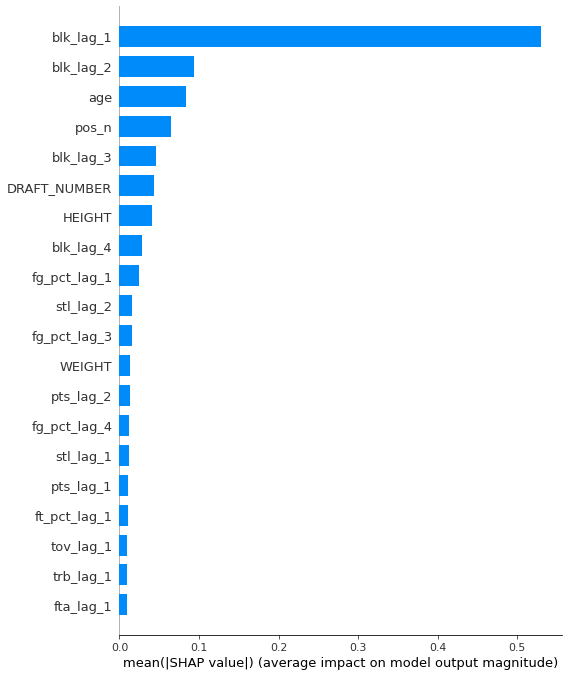

In [25]:
shap.summary_plot(shap_values_blk, future_x.dropna(), plot_type="bar")

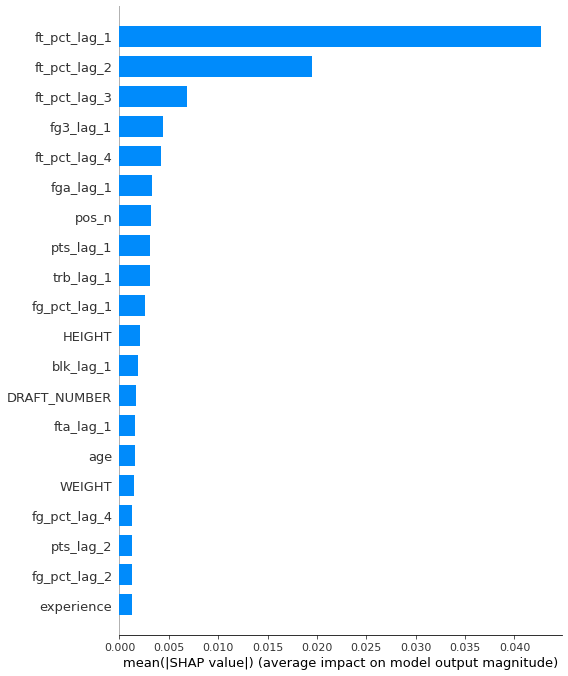

In [26]:
shap.summary_plot(shap_values_ftp, future_x.dropna(), plot_type="bar")

In [59]:
shap.initjs()

player = 'Shai Gilgeous-Alexander'

shap.force_plot(explainer_ftp.expected_value
                , shap_values_ftp[future_x.dropna().index.get_level_values('player') == player]
                , future_x.loc[player])


In [60]:
player = 'Kevin Durant'

shap.force_plot(explainer_ftp.expected_value
                , shap_values_ftp[future_x.dropna().index.get_level_values('player') == player]
                , future_x.loc[player])


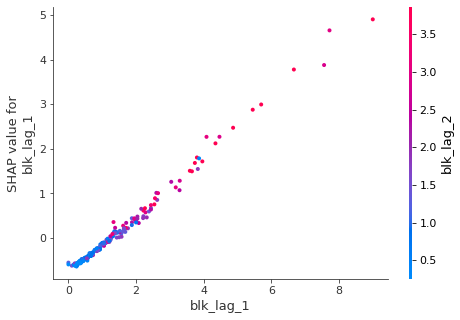

In [61]:
shap.dependence_plot('blk_lag_1'
                     , shap_values_blk
                     , future_x.dropna()
                     , interaction_index = 'blk_lag_2', display_features=future_x.dropna())

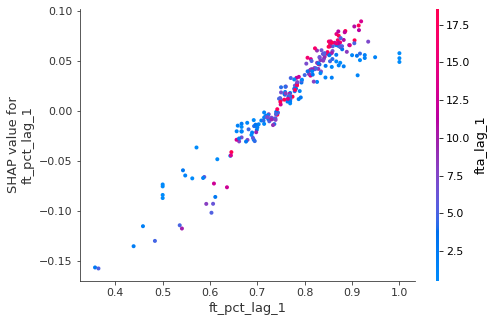

In [62]:
shap.dependence_plot('ft_pct_lag_1'
                     , shap_values_ftp
                     , future_x.dropna()
                     , interaction_index = 'fta_lag_1', display_features=future_x.dropna())

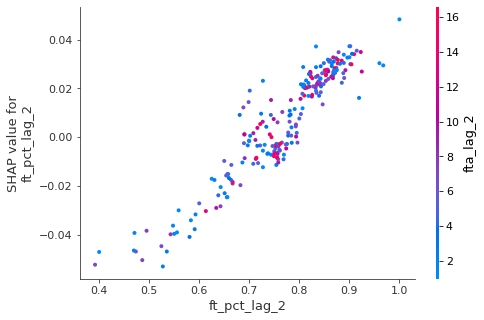

In [591]:
shap.dependence_plot('ft_pct_lag_2'
                     , shap_values_ftp
                     , future_x.dropna()
                     , interaction_index = 'fta_lag_2', display_features=future_x.dropna())

In [593]:
train_x[(train_x['ft_pct_lag_1'] > 0.9) & (train_x['fta_lag_1'] > 10) & (train_x['ft_pct_lag_2'] < 0.85)]

,,pts_lag_1,trb_lag_1,ast_lag_1,stl_lag_1,blk_lag_1,fg3_lag_1,tov_lag_1,fta_lag_1,ft_pct_lag_1,fga_lag_1,...,ft_pct_lag_4,fga_lag_4,fg_pct_lag_4,no_play_lag_4,age,experience,DRAFT_NUMBER,HEIGHT,WEIGHT,pos_n
season,player,,,,,,,,,,,,,,,,,,,,,
2012,D.J. Augustin,47.120000,9.000000,19.920000,2.160000,0.120000,4.440000,6.200000,11.880000,0.905724,38.320000,...,NaN,NaN,NaN,NaN,24.0,4,9.0,71.0,183.0,5
2014,Stephen Curry,71.440000,12.560000,21.560000,5.040000,0.480000,10.880000,9.600000,11.640000,0.900344,55.520000,...,0.885000,45.72,0.461942,0.0,25.0,5,7.0,74.0,185.0,5
2018,CJ McCollum,76.541667,12.041667,11.875000,3.000000,1.750000,7.708333,7.166667,11.760000,0.911565,57.640000,...,0.676471,7.12,0.415730,0.4,26.0,5,10.0,75.0,190.0,11
2021,Bojan Bogdanovic,60.714286,12.333333,6.238095,1.619048,0.333333,9.000000,7.571429,11.541667,0.902527,38.958333,...,0.893004,33.80,0.444970,0.0,31.0,7,31.0,79.0,226.0,7


In [64]:
z = train[(train_x['ft_pct_lag_1'] > 0.88) & \
          (train_x['fta_lag_1'] > 10) & \
          (train_x['ft_pct_lag_2'] < 0.85) & \
          (train_x['fta_lag_2'] > 10)]

In [65]:
z['ft_pct'].mean()

0.8702946971085748

In [613]:
z['ft_pct_lag_1']

season  player          
2010    David West          0.884337
2018    Ricky Rubio         0.891228
2021    Bojan Bogdanovic    0.902527
Name: ft_pct_lag_1, dtype: float64

In [ ]:
shap.dependence_plot('blk_lag_1', shap_values, future_x.dropna(), display_features=future_x.dropna())

In [543]:
X_display,y_display = shap.datasets.adult(display=True)

In [544]:
X_display

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27.0,Private,12.0,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38.0,United-States
32557,40.0,Private,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States
32558,58.0,Private,9.0,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,40.0,United-States
32559,22.0,Private,9.0,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,20.0,United-States


In [537]:
full_x.columns

Index(['pts_lag_1', 'trb_lag_1', 'ast_lag_1', 'stl_lag_1', 'blk_lag_1',
       'fg3_lag_1', 'tov_lag_1', 'fta_lag_1', 'ft_pct_lag_1', 'fga_lag_1',
       'fg_pct_lag_1', 'no_play_lag_1', 'pts_lag_2', 'trb_lag_2', 'ast_lag_2',
       'stl_lag_2', 'blk_lag_2', 'fg3_lag_2', 'tov_lag_2', 'fta_lag_2',
       'ft_pct_lag_2', 'fga_lag_2', 'fg_pct_lag_2', 'no_play_lag_2',
       'pts_lag_3', 'trb_lag_3', 'ast_lag_3', 'stl_lag_3', 'blk_lag_3',
       'fg3_lag_3', 'tov_lag_3', 'fta_lag_3', 'ft_pct_lag_3', 'fga_lag_3',
       'fg_pct_lag_3', 'no_play_lag_3', 'pts_lag_4', 'trb_lag_4', 'ast_lag_4',
       'stl_lag_4', 'blk_lag_4', 'fg3_lag_4', 'tov_lag_4', 'fta_lag_4',
       'ft_pct_lag_4', 'fga_lag_4', 'fg_pct_lag_4', 'no_play_lag_4', 'age',
       'experience', 'DRAFT_NUMBER', 'HEIGHT', 'WEIGHT', 'pos_n'],
      dtype='object')

In [557]:
shap.dependence_plot("ft_pct_lag_1", shap_values, full_x.dropna().values[:10000,:])

ValueError: Could not find feature named: ft_pct_lag_1

In [517]:
m.predict(future_x.loc[['Shai Gilgeous-Alexander']])

array([-0.04454789])

In [212]:
def get_grid_options(n):
    
def get_random_options(n): #use RandomizedSearchCV? also try it a bunch of times to get a range
    
def get_circle_packing_options(n):
    
    
run_hyperparam_tuning('pts', [{'num_leaves' : 16, 'n_estimators' : 69}])

IndentationError: expected an indented block (2221150783.py, line 3)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

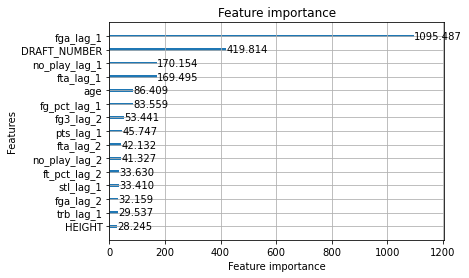

In [213]:
plot_importance(train_models['no_play'], max_num_features = 15)

In [485]:
p = future_x.loc['Shai Gilgeous-Alexander']
p.loc['ft_pct_lag_1'] = 1

In [486]:
full_models['ft_pct'].predict(p.values.reshape(1,-1))

array([0.84241972])

In [9]:
g_scores_2023.sort_values('total', ascending = False)[0:30]

NameError: name 'g_scores_2023' is not defined

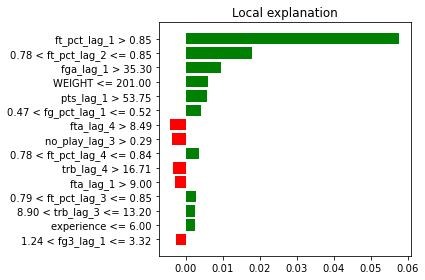

In [476]:
#check LIME for SGA's free-throw percentage
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(future_x.dropna().values,
    feature_names=full_x.columns,
    mode='regression')

exp = explainer.explain_instance(future_x.loc['Shai Gilgeous-Alexander']
        , full_models['ft_pct'].predict,
        num_features=15)

exp.as_pyplot_figure()
from matplotlib import pyplot as plt
plt.tight_layout()

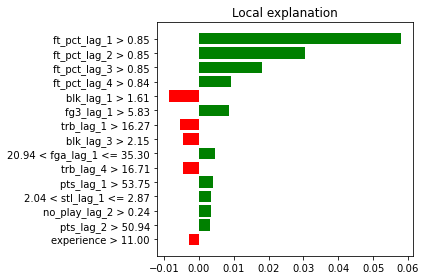

In [475]:
#check LIME for SGA's free-throw percentage
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(future_x.dropna().values,
    feature_names=full_x.columns,
    mode='regression')

exp = explainer.explain_instance(future_x.loc['Kevin Durant']
        , full_models['ft_pct'].predict,
        num_features=15)

exp.as_pyplot_figure()
from matplotlib import pyplot as plt
plt.tight_layout()

In [36]:
def get_coefficients_from_season(season_df, n_players = 12 * 13):   
    
    all_players = pd.unique(season_df.index.get_level_values('player'))
    mean_of_means_1, var_of_means_1, mean_of_vars_1 = calculate_coefficients(season_df, all_players)
    first_order_scores = calculate_scores_from_coefficients(season_df
                                                       ,mean_of_means_1
                                                       ,var_of_means_1
                                                       ,mean_of_vars_1
                                                       ,alpha_weight = 1
                                                       ,beta_weight = 0)

    first_order_score_totals = first_order_scores.sum(axis = 1).sort_values(ascending = False)

    representative_player_set = first_order_score_totals.index[0:n_players]
    mean_of_means_2, var_of_means_2, mean_of_vars_2 = calculate_coefficients(season_df, representative_player_set)
    
    return mean_of_means_2,var_of_means_2,mean_of_vars_2

season_df_2022, _ = setup(2022)
season_df_2023, _ = setup(2023)

mean_of_means_2022, var_of_means_2022, mean_of_vars_2022 = get_coefficients_from_season(season_df_2022)
mean_of_means_2023, var_of_means_2023, mean_of_vars_2023 = get_coefficients_from_season(season_df_2023)

future_predictions.loc[:,'ft'] = future_predictions['fta'] * future_predictions['ft_pct']
future_predictions.loc[:,'fg'] = future_predictions['fga'] * future_predictions['fg_pct']


g_scores_2022 = calculate_scores_from_coefficients(season_df_2022
                                                   ,mean_of_means_2022
                                                   ,var_of_means_2022
                                                   ,mean_of_vars_2022
                                                   ,alpha_weight = 1
                                                   ,beta_weight = 1)

g_scores_2023 = calculate_scores_from_coefficients(season_df_2023
                                                   ,mean_of_means_2023
                                                   ,var_of_means_2023
                                                   ,mean_of_vars_2023
                                                   ,alpha_weight = 1
                                                   ,beta_weight = 1)

g_scores_forecast = calculate_scores_from_coefficients(future_predictions
                                                   ,mean_of_means_2023
                                                   ,var_of_means_2023
                                                   ,mean_of_vars_2023
                                                   ,alpha_weight = 1
                                                   ,beta_weight = 1)

g_scores_2023_uninjured = calculate_scores_from_coefficients(season_df_2023[season_df_2023.sum(axis =1) != 0]
                                   ,mean_of_means_2023
                                   ,var_of_means_2023
                                   ,mean_of_vars_2023
                                   ,alpha_weight = 1
                                   ,beta_weight = 1)

In [37]:
g_scores_2022.loc[:,'total'] = g_scores_2022.sum(axis =1)
g_scores_2023.loc[:,'total'] = g_scores_2023.sum(axis =1)
g_scores_2023_uninjured.loc[:,'total'] = g_scores_2023_uninjured.sum(axis =1)
g_scores_forecast.loc[:,'total'] = g_scores_forecast.sum(axis =1)

In [39]:
top_players = g_scores_2023.sort_values('total', ascending = False).index[0:156]
season_df.loc[top_players]['blk'].to_csv('blk_2023.csv')

In [78]:
mean_of_means_2024

pts       27.543615
trb       10.719984
ast        6.048241
stl        1.776063
blk        1.088801
fg3        3.160328
tov        3.185024
fta        4.606524
ft_pct     0.778652
fga       18.597484
fg_pct     0.469485
dtype: float64

In [47]:
g_scores_forecast.loc[:,'total_no_tov'] = g_scores_forecast.drop(columns = ['tov','total','total_no_tov']).sum(axis =1)


In [48]:
g_scores_forecast.sort_values('total', ascending = False)[0:10]

,pts,trb,ast,stl,blk,fg3,tov,ft_pct,fg_pct,total,total_no_tov
player,,,,,,,,,,,
Nikola Jokic,1.150275,1.595656,2.075286,0.427035,0.062503,-0.305646,-1.521052,0.397282,1.549389,5.430728,6.951780
Kevin Durant,1.358603,0.368041,0.683197,-0.221374,1.139272,0.385767,-1.160551,0.804911,0.770903,4.128769,5.289321
Joel Embiid,1.470030,1.231690,0.240278,0.088958,1.095537,-0.431489,-0.998420,0.579284,0.586280,3.862147,4.860567
Jayson Tatum,1.407140,0.802519,0.520944,0.323374,0.073834,0.998730,-0.856811,0.670150,-0.362834,3.577044,4.433855
Tyrese Haliburton,0.562439,-0.446484,1.937794,0.988376,-0.189847,0.940317,-0.598235,0.376479,-0.108036,3.462804,4.061039
Stephen Curry,1.209258,0.043112,1.017492,-0.091298,-0.403674,1.978740,-1.150586,0.712328,-0.255713,3.059658,4.210245
Jaren Jackson Jr.,0.430004,0.189529,-0.763535,0.157276,2.468663,0.177212,0.049137,-0.024837,-0.024057,2.659392,2.610255
Anthony Davis,0.673682,1.469657,-0.330636,0.073441,1.565554,-0.723989,-0.246671,-0.426715,0.566689,2.621012,2.867682
Luka Doncic,1.496343,0.581160,1.514230,0.420878,-0.159490,1.007820,-1.426848,-0.909900,-0.094999,2.429193,3.856042


In [82]:
future_predictions

,pts,trb,ast,stl,blk,fg3,tov,fta,ft_pct,fga,fg_pct,no_play,ft,fg,volume_adjusted_ftp,volume_adjusted_fgp
player,,,,,,,,,,,,,,,,
Marko Simonovic,8.295182,5.424816,0.910393,0.582231,1.192808,0.747998,1.065592,1.424486,0.735294,4.261125,0.502520,0.504838,1.047416,2.141299,0.0,0.0
Marvin Bagley III,29.190970,17.391967,2.285557,1.142519,1.660370,1.692605,2.706920,4.270022,0.764902,17.228175,0.514602,0.215274,3.266146,8.865659,0.0,0.0
Mason Plumlee,29.679258,23.084441,8.858583,1.890987,1.855762,-0.047229,4.643235,9.604217,0.527160,15.657417,0.669176,0.134884,5.062961,10.477570,0.0,0.0
Matisse Thybulle,15.543243,7.261810,3.027168,3.561875,1.993073,2.831030,1.532652,1.749233,0.736336,13.049164,0.436796,0.220909,1.288024,5.699826,0.0,0.0
Matt Ryan,12.474295,4.206641,1.479191,0.695315,0.390761,3.629791,1.158288,1.294885,0.784848,7.073102,0.417359,0.440926,1.016288,2.952022,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hamidou Diallo,26.207217,9.567354,3.377625,2.823561,0.811383,0.604066,3.323051,6.214124,0.674301,17.505213,0.529148,0.200135,4.190188,9.262853,NaN,NaN
Greg Brown III,10.498917,6.608961,1.232358,1.141142,0.804915,0.468889,1.435058,1.654785,0.717909,6.604550,0.465140,0.510223,1.187985,3.072040,NaN,NaN
Grayson Allen,28.923230,9.271754,6.419531,2.308745,0.597806,5.720076,2.808806,4.391172,0.886377,22.670536,0.448233,0.114792,3.892232,10.161689,NaN,NaN


In [621]:
g_scores_2023.to_csv('g_scores_2023.csv')

In [72]:
g_scores_2022.sort_values('total', ascending = False)[0:10]

,pts,trb,ast,stl,blk,fg3,tov,ft_pct,fg_pct,total
player,,,,,,,,,,
Nikola Jokic,1.388904,2.175459,1.718374,0.770809,0.371562,-0.133383,-1.668077,0.212389,1.605744,12.883562
Joel Embiid,1.496846,1.395222,0.275994,0.207348,1.051710,-0.170757,-0.990368,0.456608,0.349955,8.145115
Karl-Anthony Towns,1.121209,1.153803,0.203875,0.119307,0.749422,0.361818,-1.111748,0.356409,0.732349,7.372887
Trae Young,1.606227,-0.396174,2.453987,0.119307,-0.686445,1.137321,-1.890608,1.548151,-0.284659,7.214213
Jayson Tatum,1.449351,0.740943,0.516390,0.172131,0.107060,1.109291,-1.020713,0.714916,-0.429068,6.720603
Dejounte Murray,0.574305,0.579997,1.925115,1.281447,-0.384157,-0.142727,-0.646456,0.011934,-0.211173,5.976570
Tyrese Haliburton,0.204425,-0.301706,1.929923,1.211014,0.107060,0.464595,-0.838642,0.238724,-0.036054,5.958678
LaMelo Ball,0.675050,0.363070,1.655870,0.946891,-0.251907,1.015857,-1.303935,0.488548,-0.685950,5.806990
Giannis Antetokounmpo,1.386026,1.332243,0.776019,0.119307,0.900566,-0.376312,-1.040943,-1.326660,1.103796,5.748084


In [73]:
g_scores_2023_uninjured.sort_values('total', ascending = False)[0:30]

,pts,trb,ast,stl,blk,fg3,tov,ft_pct,fg_pct,total
player,,,,,,,,,,
Kevin Durant,1.587690,0.455693,0.670837,-0.143698,1.218127,0.416905,-1.399082,1.463138,1.117878,5.387488
Nikola Jokic,0.881654,1.660399,2.163666,0.457124,0.083347,-0.480136,-1.370864,0.200249,1.675898,5.271337
Joel Embiid,1.719200,1.211322,0.225525,0.122978,1.400400,-0.364150,-1.249592,1.051671,0.928916,5.046269
Stephen Curry,1.439651,0.188756,1.010093,0.064271,-0.326396,2.332567,-1.144091,0.934273,0.052925,4.552049
Anthony Davis,0.954594,1.757171,-0.309882,0.158556,1.776092,-0.814327,-0.279042,-0.210175,0.976819,4.009806
Jayson Tatum,1.517029,0.921421,0.435149,0.233751,0.120293,1.214275,-0.909390,0.730397,-0.412550,3.850375
Damian Lillard,1.512145,-0.246208,1.213171,-0.093147,-0.414836,1.687783,-1.059225,1.669522,-0.438384,3.830821
Shai Gilgeous-Alexander,1.393943,-0.248995,0.572766,0.835310,0.373639,-0.493034,-0.690591,1.714470,0.300188,3.757696
Tyrese Haliburton,0.457120,-0.515082,2.282301,0.866273,-0.237106,0.850768,-0.526492,0.389627,-0.003347,3.564062


In [74]:
g_scores_forecast.sort_values('total', ascending = False)[0:30]

,pts,trb,ast,stl,blk,fg3,tov,ft_pct,fg_pct,total
player,,,,,,,,,,
Nikola Jokic,1.150275,1.595656,2.075286,0.427035,0.062503,-0.305646,-1.521052,0.397282,1.549389,5.430728
Kevin Durant,1.358603,0.368041,0.683197,-0.221374,1.139272,0.385767,-1.160551,0.804911,0.770903,4.128769
Joel Embiid,1.470030,1.231690,0.240278,0.088958,1.095537,-0.431489,-0.998420,0.579284,0.586280,3.862147
Jayson Tatum,1.407140,0.802519,0.520944,0.323374,0.073834,0.998730,-0.856811,0.670150,-0.362834,3.577044
Tyrese Haliburton,0.562439,-0.446484,1.937794,0.988376,-0.189847,0.940317,-0.598235,0.376479,-0.108036,3.462804
Stephen Curry,1.209258,0.043112,1.017492,-0.091298,-0.403674,1.978740,-1.150586,0.712328,-0.255713,3.059658
Jaren Jackson Jr.,0.430004,0.189529,-0.763535,0.157276,2.468663,0.177212,0.049137,-0.024837,-0.024057,2.659392
Anthony Davis,0.673682,1.469657,-0.330636,0.073441,1.565554,-0.723989,-0.246671,-0.426715,0.566689,2.621012
Luka Doncic,1.496343,0.581160,1.514230,0.420878,-0.159490,1.007820,-1.426848,-0.909900,-0.094999,2.429193


In [629]:
season_df_2023.loc['Brook Lopez']

,pts,trb,ast,stl,blk,fg3,tov,fg,fga,ft,fta,volume_adjusted_ftp,volume_adjusted_fgp
week,,,,,,,,,,,,,
42,26.0,9.0,3.0,2.0,7.0,7.0,1.0,9.0,23.0,1.0,2.0,-0.074792,-0.089087
43,42.0,23.0,3.0,2.0,11.0,6.0,3.0,16.0,35.0,4.0,4.0,0.113573,-0.071486
44,67.0,27.0,3.0,2.0,5.0,8.0,9.0,27.0,46.0,5.0,6.0,0.038781,0.072105
45,54.0,18.0,3.0,2.0,9.0,7.0,7.0,21.0,46.0,5.0,7.0,-0.064404,-0.094747
46,56.0,14.0,4.0,2.0,7.0,9.0,2.0,18.0,33.0,11.0,13.0,0.105956,0.013641
47,55.0,19.0,4.0,3.0,16.0,9.0,3.0,22.0,38.0,2.0,4.0,-0.149584,0.051101
48,36.0,19.0,5.0,0.0,11.0,7.0,4.0,10.0,26.0,9.0,9.0,0.255540,-0.105543
49,28.0,18.0,3.0,0.0,7.0,3.0,2.0,9.0,27.0,7.0,7.0,0.198753,-0.148107
50,29.0,18.0,4.0,0.0,5.0,2.0,2.0,12.0,26.0,3.0,5.0,-0.121191,-0.049926


In [625]:
g_scores_forecast.sort_values('total', ascending = False)[0:35]

,pts,trb,ast,stl,blk,fg3,tov,ft_pct,fg_pct,total
player,,,,,,,,,,
Nikola Jokic,1.148473,1.694301,2.037049,0.444615,0.147785,-0.311407,-1.420074,0.222800,1.611544,5.575086
Kevin Durant,1.197585,0.524971,0.591707,-0.234269,1.127014,0.470623,-1.033509,0.684909,0.774329,4.103362
Joel Embiid,1.284268,1.372018,0.237010,0.084854,0.860601,-0.476376,-0.866145,0.621460,0.589304,3.706995
Jayson Tatum,1.502171,0.850184,0.591285,0.280602,0.052648,0.971090,-0.865309,0.681657,-0.399653,3.664675
Tyrese Haliburton,0.532407,-0.437728,1.938531,1.078512,-0.149682,0.941535,-0.714608,0.356184,-0.117914,3.427235
Anthony Davis,0.685536,1.532046,-0.328307,0.050768,1.600436,-0.678976,-0.194215,-0.334783,0.657345,2.989850
Stephen Curry,1.027775,-0.029035,0.972365,-0.074856,-0.397740,2.076956,-1.229806,0.784089,-0.223545,2.906201
Jaren Jackson Jr.,0.462697,0.182245,-0.740329,0.181790,2.440146,0.143303,0.017824,0.101675,0.049546,2.838897
James Harden,0.363950,0.117589,2.090079,0.366596,-0.146758,0.673346,-1.017110,0.634326,-0.533597,2.548422


In [40]:
g_scores_2022.loc[:,'total'] = g_scores_2022.sum(axis = 1)
g_scores_2023.loc[:,'total'] = g_scores_2023.sum(axis = 1)

In [220]:
future_predictions_counting_diff = future_predictions[counting_statistics] - mean_of_means[counting_statistics]
future_predictions_counting_diff['tov'] = - future_predictions_counting_diff['tov']

In [276]:
g_scores_2022.loc['Evan Mobley']

pts      -0.007141
trb       0.604489
ast      -0.252879
stl      -0.162424
blk       1.353998
fg3      -0.824796
tov      -0.171048
ft_pct   -0.807637
fg_pct    0.305586
total     0.038147
Name: Evan Mobley, dtype: float64

In [284]:
future_predictions.loc['Tyrese Haliburton']

pts        63.033696
trb        11.187755
ast        25.620106
stl         4.895062
blk         1.380579
fg3         8.527299
tov         7.394289
fta         9.787278
ft_pct      0.880048
fga        39.625535
fg_pct      0.484089
no_play     0.096351
Name: Tyrese Haliburton, dtype: float64

In [62]:
w = train[(train['fta_lag_1'] > 8) & (train['ft_pct_lag_1'] > 0.9)]
(w['ft_pct'] * w['fta']).sum()/ w['fta'].sum()

0.8927976178394906

In [77]:
future_predictions.to_csv('predictions.csv')
mean_of_means_2023.to_csv('mean_of_means.csv')
var_of_means_2023.to_csv('var_of_means.csv')
mean_of_vars_2023.to_csv('mean_of_vars.csv')

In [ ]:
"""
counting_stats = ['pts','trb','ast','stl','blk','fg3']
percent_stats= ['ft_pct','fg_pct']

counting_stats_injury_penalty = pd.DataFrame(
    {k : v * future_predictions['no_play'] for k,v in future_predictions[counting_stats].min(axis = 0).items()
                                            }
)
counting_stats_injury_adjusted = future_predictions[counting_stats].mul(( 1 - future_predictions['no_play']),axis = 0) + \
                                            counting_stats_injury_penalty


turnovers_injury_adjusted = future_predictions['tov'].mul(( 1 - future_predictions['no_play']),axis = 0) + \
                                        future_predictions['no_play'] * future_predictions['tov'].max()
turnovers_injury_adjusted.name = 'tov'

percentage_stats_injury_adjusted = future_predictions[percent_stats].mul(( 1 - future_predictions['no_play']),axis = 0)

full_adjusted_df = pd.concat(
    [counting_stats_injury_adjusted,turnovers_injury_adjusted, percentage_stats_injury_adjusted]
    , axis = 1)
full_adjusted_df.loc[:,'g_total'] = full_adjusted_df.sum(axis = 1)
final_df = full_adjusted_df.merge(future['pos'], left_index = True, right_index = True)

counting_stats = ['pts','trb','ast','stl','blk','fg3']
percent_stats= ['ft_pct','fg_pct']

counting_stats_injury_penalty = pd.DataFrame(
    {k : v * future_predictions['no_play'] for k,v in future_predictions[counting_stats].min(axis = 0).items()
                                            }
)
counting_stats_injury_adjusted = future_predictions[counting_stats].mul(( 1 - future_predictions['no_play']),axis = 0) + \
                                            counting_stats_injury_penalty


turnovers_injury_adjusted = future_predictions['tov'].mul(( 1 - future_predictions['no_play']),axis = 0) + \
                                        future_predictions['no_play'] * future_predictions['tov'].max()
turnovers_injury_adjusted.name = 'tov'

percentage_stats_injury_adjusted = future_predictions[percent_stats].mul(( 1 - future_predictions['no_play']),axis = 0)

full_adjusted_df = pd.concat(
    [counting_stats_injury_adjusted,turnovers_injury_adjusted, percentage_stats_injury_adjusted]
    , axis = 1)
full_adjusted_df.loc[:,'g_total'] = full_adjusted_df.sum(axis = 1)
final_df = full_adjusted_df.merge(future['pos'], left_index = True, right_index = True)
"""


## 4. Converting to auction value

below here experimental

Now that we have predicted G-score values, converting into auction values is simple

In [15]:
n = 12
total_players = n * 13 
total_money = n * 200

#step 1: calculate replacement value of a player you could get on waivers 
replacement_level_value = future['OVERALL_SCORE'].sort_values(ascending = False).iloc[total_players]

#step 2: recalculate total scores by subtracting replacement value 
adjusted_value = (future['OVERALL_SCORE'] - replacement_level_value)

#step 3: calculate the total value of all players 
total_player_value = adjusted_value.sort_values(ascending = False).iloc[0:total_players].sum()

#step 4: convert player value to monetary value
monetary_value = adjusted_value * total_money/total_player_value
monetary_value = np.where(monetary_value >0, monetary_value, 0 )

future.loc[:,'AUCTION_VALUE_' + str(n)] = monetary_value

In [16]:
future.loc[:, 'rank'] = future['OVERALL_SCORE'].rank(ascending = False)
future_formatted = future[['rank','PLAYER_NAME','OVERALL_SCORE','AUCTION_VALUE_12','G_PRED'
                          ,'TOTAL_SCORE_LAG_1','TOTAL_SCORE_LAG_2','TOTAL_SCORE_LAG_3','TOTAL_SCORE_LAG_4'
                          ,'I_PRED','INJURY_RATE_LAG_1','INJURY_RATE_LAG_2','INJURY_RATE_LAG_3','INJURY_RATE_LAG_4'
                          ,'age','pos','experience','HEIGHT','WEIGHT','DRAFT_NUMBER']].sort_values('OVERALL_SCORE', ascending = False)
future_formatted.to_csv('predictions.csv', index = False)

In [17]:
future[['PLAYER_NAME','AUCTION_VALUE_12']].sort_values('AUCTION_VALUE_12', ascending = False)[0:total_players]

,PLAYER_NAME,AUCTION_VALUE_12
10640,Nikola Jokic,52.299938
10644,Luka Doncic,51.058896
10648,Jayson Tatum,50.905954
10641,Joel Embiid,46.434967
10646,Shai Gilgeous-Alexander,44.371750
10642,Damian Lillard,41.252768
10651,Tyrese Haliburton,40.961222
10655,Domantas Sabonis,36.691710
10674,Anthony Edwards,35.415726
10643,Anthony Davis,34.629813


For fun: we can calculate the most efficient packing of 13 players, to get to exactly $200 of value

In [18]:
future_positive = future[future['AUCTION_VALUE_12'] > 0 ]
x = cp.Variable(future_positive.shape[0], boolean = True)
constraints = [cp.sum(x) == 13
               , cp.sum(x@future_positive['AUCTION_VALUE_12'].values) <= 200
               , cp.sum(x@(future_positive['pos'] == 'C')) >= 3
               , cp.sum(x@(future_positive['pos'] == 'PG')) >= 1
               , cp.sum(x@(future_positive['pos'] == 'SG')) >= 1
               , cp.sum(x@(future_positive['pos'] == 'PG')) + cp.sum(x@(future_positive['pos'] == 'SG')) >= 4
               , cp.sum(x@(future_positive['pos'] == 'PF')) >= 1
               , cp.sum(x@(future_positive['pos'] == 'SF')) >= 1
               , cp.sum(x@(future_positive['pos'] == 'PF')) + cp.sum(x@(future_positive['pos'] == 'SF')) >= 4
              ]
objective = cp.Maximize(x@future_positive['AUCTION_VALUE_12'].values)
prob = cp.Problem(objective, constraints)
result = prob.solve()
future_positive[x.value == 1][['PLAYER_NAME','AUCTION_VALUE_12','pos']].sort_values('AUCTION_VALUE_12', ascending = False)

,PLAYER_NAME,AUCTION_VALUE_12,pos
10646,Shai Gilgeous-Alexander,44.371750,SG
10650,Kyrie Irving,32.031647,PG
10654,Jimmy Butler,23.840767,SF
10714,Terry Rozier,14.419278,PG
10696,Clint Capela,13.548718,C
10720,Jakob Poeltl,12.403032,C
10700,Jerami Grant,11.229549,PF
10736,Derrick White,10.639474,SG
10740,Josh Hart,10.444459,SG
10719,Aaron Gordon,9.884895,PF


In [19]:
result

199.9967359290051

We can get very close to exactly $200 of value, even with our position constraints